### Cardiac Arrhythmia Multi-Class Classification 

Analyze data and address missing data if there is any. 

Decide aboute a good evaluation strategy and justify your choice. 

Find the best parameters for the following classification models: 
- KNN classifcation 
- Logistic Regression
- Linear Supprt Vector Machine
- Kerenilzed Support Vector Machine
- Decision Tree
- Random Forest 

Then use different bagging and boosting methods to boost the results? Do you see any significant change? Why or why not? 

Next, use data reduction method you have learned in class to reduce the size of data, and agian try above models. Do you get better results? Justify your answer. 


## Import all the required libraries

In [151]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.decomposition import PCA


from sklearn import linear_model, decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings; warnings.simplefilter('ignore')

In [152]:
pwd


'C:\\Users\\praya\\Data_Science\\Projects\\Detection-of-Cardiac-Arrhythmia-master'

Read the Dataset. There are no column names in the dataset

In [153]:
df = pd.read_csv('cardiac_arrhythmia.csv', header=None, na_values=['?'])

In [156]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


Created the Column names list by taking information from the metadata document

In [157]:
column_names = ["Age", "Gender", "Height", "Weight", "QRS_Duration", "PR_Interval",
           "QT_Interval","T_Interval","P_Interval"]

for name in ["QRS","T","P","QRST","J"]:
    column_names.append("VectorAngle_"+name)
    
column_names.append("HeartRate")

channels = ["DI","DII","DIII","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]
channel_specs_1 = ["Q_Width","R_Width","S_Width","RP_Width","SP_Width","Int_Deflections",
                 "ExistRagR","ExistDiaR","ExistRagP","ExistDiaP","ExistRagT","ExistDiaT"]

for channel in channels:
    for spec in channel_specs_1:
        column_names.append(channel+"_"+spec)
        
channel_specs_2 = ["AmpJJ","AmpQ","AmpR","AmpS","AmpRP","AmpSP","AmpP","AmpT","QRSA","QRSTA"]

for channel in channels:
    for spec in channel_specs_2:
        column_names.append(channel+"_"+spec)
        
column_names.append("Target")



In [158]:
#Seperate Nominal and Linear columns for future

channels = ["DI","DII","DIII","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]
channel_spec = ["ExistRagR","ExistDiaR","ExistRagP","ExistDiaP","ExistRagT","ExistDiaT"]

NominalCols = ["Gender"]

for channel in channels:
    for spec in channel_spec:
        NominalCols.append(channel+"_"+spec)

LinearCols = [i for i in column_names if i not in NominalCols]


#Remove the "Target" column from LinearCols
LinearCols = LinearCols[:-1] 

        


Add Column names in the dataframe

In [159]:
df.columns = column_names
df.head()

,Age,Gender,Height,Weight,QRS_Duration,PR_Interval,QT_Interval,T_Interval,P_Interval,VectorAngle_QRS,...,V6_AmpQ,V6_AmpR,V6_AmpS,V6_AmpRP,V6_AmpSP,V6_AmpP,V6_AmpT,V6_QRSA,V6_QRSTA,Target
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, Age to Target
dtypes: float64(121), int64(159)
memory usage: 988.8 KB


## Handling Missing Values

In [161]:
np.array(df.isnull().sum())


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   8,  22,   1,
       376,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

Only 4 columns have missing values

We will impute the missing values with mean of the column as a replacement of missing value. 

In [163]:
df = df.fillna(df.mean())


In [164]:
np.array(df.isnull().sum())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## Data Cleaning
Let us check if the nominal columns have more than 2 values. If there are, we might want to convert them to one_hot array.

Let us also Print the columns which have only one value as they will be of no use in the analysis

In [165]:
print('Nominal Columns')
for col in NominalCols:
    if len(df[col].unique()) != 2:
        print("Unique values in "+col+" column are: ",end="")
        print(df[col].unique())

Nominal Columns
Unique values in AVL_ExistRagR column are: [0]
Unique values in AVF_ExistRagP column are: [0]
Unique values in V4_ExistRagP column are: [0]
Unique values in V4_ExistDiaP column are: [0]
Unique values in V5_ExistRagR column are: [0]
Unique values in V5_ExistRagP column are: [0]
Unique values in V5_ExistRagT column are: [0]
Unique values in V6_ExistDiaP column are: [0]
Unique values in V6_ExistRagT column are: [0]


In [166]:
print('Linear Columns')
for col in LinearCols:
    if len(df[col].unique()) == 1:
        print("Unique values in "+col+" column are: ",end="")
        print(df[col].unique())

Linear Columns
Unique values in DI_SP_Width column are: [0]
Unique values in AVL_SP_Width column are: [0]
Unique values in V5_SP_Width column are: [0]
Unique values in V6_SP_Width column are: [0]
Unique values in DI_AmpSP column are: [0]
Unique values in AVL_AmpSP column are: [0]
Unique values in V5_AmpSP column are: [0]
Unique values in V6_AmpSP column are: [0]


1) No nominal columns have more than 2 values. So we don't have to convert any column to one hot array.

2) Few nominal and linear columns have only one value so remove them and update the NominalCols and LinearCols list.

In [167]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)

#Update the nominal and linear columns list
NominalCols = [i for i in NominalCols if i in df.columns]
LinearCols = [i for i in LinearCols if i in df.columns]

## Modeling

Models built will be  
1) Logistic Regression (Multinomial and OneVsRest)      
2) Support Vector Classifier (linear and rbf kernels)  
3) Decision Tree Classifier  
4) Random Forests  
5) K Nearest Neighbors  
6) Gradient Boosting Classifier  



Let us seperate the features and target in the dataset and do min max scaling

In [116]:
X = df[df.columns[:-1]]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify = y)

scaler = StandardScaler()

X_train_scaled1 = scaler.fit_transform(X_train)
X_test_scaled1 = scaler.transform(X_test)

X_scaled1 = scaler.fit_transform(X)




A few helper functions are used for the analysis.  
1) multiclass_roc_auc_score: Scikit learn's roc_auc functions work only for binary classfication problem, this function calculates the AUC for the multiclass classification problem we have.  
2) var_imp_plot: This function plots the important variables for the different models that we plot   
3) print_grid_search: This function plots few metrics from grid search of use to us  
4) print_model_scores: This functions prints a few results we want from a model like classification report etc.  

In [136]:
def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return(roc_auc_score(truth, pred, average=average))



def var_imp_plot(model, df = df):
    
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    column_names = df.columns[:-1]

    imp = list(zip(column_names, feature_importance))
    x = sorted(imp, reverse=True, key= lambda x: x[1])[0:20][::-1]

    sorted_idx = np.argsort(feature_importance)[0:20]
    pos = np.arange(sorted_idx.shape[0])+0.5

    plt.subplot(1, 2, 2)
    plt.barh(pos, [a[1] for a in x], align='center')
    plt.yticks(pos, [a[0] for a in x])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    
def print_grid_search(grid_search):
    
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    print( "Best estimator:\n{}".format(grid_search.best_estimator_))

    
def print_model_scores(model, y_test = y_test, X_test_scaled = X_test_scaled, X_train_scaled = X_train_scaled, y_train = y_train):
    
    y_predicted = model.predict(X_test_scaled)
    
    print("training score : %.4f " % (model.score(X_train_scaled, y_train)))
    print("testing score : %.4f " % (model.score(X_test_scaled, y_test)))
    
    print("Testing report :")
    print(classification_report(y_test, y_predicted))
    
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_predicted))
    
    print("AUC: {:.4f}".format(multiclass_roc_auc_score(y_test, y_predicted)))
    

## PCA to improve the speed

In [131]:
pca = PCA(0.95)

X_train_scaled = pca.fit_transform(X_train_scaled1)


# 

In [132]:
X_test_scaled = pca.transform(X_test_scaled1)

##### The model building process for each model will be as follows:  
###### 1) Do Grid Search on each model to find the best estimator   
###### 2) Use the best estimator to build that specific model  
###### 3) Bagging and Boosting (if applicable) the best estimator to try and get better results   
###### 4) Decide the best model based on the maximum accuracy and maximum roc  




Grid Search to find the best value for C in both the Multionomial and One Vs Rest

In [133]:
param_grid = {'C':[0.1,0.5,1,2,5,10]}


for multi_class in ('multinomial', 'ovr'):
    grid_search = GridSearchCV(linear_model.LogisticRegression(solver='sag', random_state=1, multi_class=multi_class),
                               param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

    grid_search.fit(X_train_scaled, y_train)
    
    print(multi_class)
    print_grid_search(grid_search)

multinomial
Best parameters: {'C': 0.1}
Best cross-validation score: 0.67
Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)
ovr
Best parameters: {'C': 0.1}
Best cross-validation score: 0.69
Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)


Building the multiclass logistic regression model for multinomial and one Versus rest

In [137]:
for multi_class, c in [('multinomial',0.1), ('ovr', 0.1)]:
    clf = linear_model.LogisticRegression(solver='sag', random_state=1, C = c,
                             multi_class=multi_class).fit(X_train_scaled, y_train)

    # print the training scores
    print(multi_class)
    print_model_scores(model = clf)

multinomial
training score : 0.9051 
testing score : 0.6765 
Testing report :
             precision    recall  f1-score   support

          1       0.72      0.95      0.82        74
          2       0.67      0.31      0.42        13
          3       1.00      1.00      1.00         4
          4       0.57      1.00      0.73         4
          5       0.00      0.00      0.00         4
          6       1.00      0.12      0.22         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.33      0.50         3
         10       0.58      0.47      0.52        15
         14       0.00      0.00      0.00         1
         15       0.50      1.00      0.67         1
         16       0.00      0.00      0.00         7

avg / total       0.65      0.68      0.62       136

Confusion matrix: 
[[70  0  0  1  0  0  0  0  0  1  0  0  2]
 [ 8  4  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  4  0  0  0  

Appliying Boosting and Bagging on both the models


In [139]:
print("Bagging")
for multi_class, c in [('multinomial',0.1), ('ovr', 0.1)]:
    clf = BaggingClassifier(linear_model.LogisticRegression(solver='sag', random_state=1, C = c,
                             multi_class=multi_class)).fit(X_train_scaled, y_train)

    # print the training scores
    print(multi_class)
    print_model_scores(model = clf)
    
print("AdaBoost")
for multi_class, c in [('multinomial',0.1), ('ovr', 0.1)]:
    clf = AdaBoostClassifier(linear_model.LogisticRegression(solver='sag', random_state=1, C = c,
                             multi_class=multi_class)).fit(X_train_scaled, y_train)

    # print the training scores
    print(multi_class)
    print_model_scores(model = clf)

Bagging
multinomial
training score : 0.8766 
testing score : 0.6912 
Testing report :
             precision    recall  f1-score   support

          1       0.71      0.97      0.82        74
          2       0.80      0.31      0.44        13
          3       0.80      1.00      0.89         4
          4       0.50      1.00      0.67         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.50      0.33      0.40         3
         10       0.82      0.60      0.69        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.60      0.69      0.62       136

Confusion matrix: 
[[72  0  0  1  0  0  0  0  0  0  0  0  1]
 [ 9  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0

## Grid Search on Support Vector Classifier to find best values for C using a linear kernel

In [140]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(kernel = 'linear', random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)

Best parameters: {'C': 0.01}
Best cross-validation score: 0.69
Best estimator:
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)


Build linear SVC using the best parameters

In [142]:
svc = SVC(C=0.01, kernel='linear', random_state=1).fit(X_train_scaled, y_train)

print_model_scores(model = svc)

training score : 0.8259 
testing score : 0.6985 
Testing report :
             precision    recall  f1-score   support

          1       0.68      0.99      0.81        74
          2       1.00      0.31      0.47        13
          3       1.00      1.00      1.00         4
          4       0.60      0.75      0.67         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.67      0.80         3
         10       0.73      0.53      0.62        15
         14       0.00      0.00      0.00         1
         15       1.00      1.00      1.00         1
         16       0.00      0.00      0.00         7

avg / total       0.62      0.70      0.63       136

Confusion matrix: 
[[73  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 8  4  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  

Bagging and boosting on SVC with linear kernel

In [143]:
svc = BaggingClassifier(SVC(C=0.01, kernel='linear', random_state=1)).fit(X_train_scaled, y_train)

print_model_scores(svc)

training score : 0.7816 
testing score : 0.6765 
Testing report :
             precision    recall  f1-score   support

          1       0.65      0.99      0.78        74
          2       1.00      0.31      0.47        13
          3       1.00      1.00      1.00         4
          4       0.60      0.75      0.67         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.67      0.80         3
         10       0.86      0.40      0.55        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.61      0.68      0.60       136

Confusion matrix: 
[[73  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 9  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  

Grid Search on Support Vector Classifier to find best values for C and gamma using a rbf kernel

In [144]:
param_grid = {'C': [1, 10, 100, 200, 400, 500],
              'gamma': [0.001, 0.01, 0.05, 0.1]}

grid_search = GridSearchCV(SVC(kernel = 'rbf', random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)

Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.69
Best estimator:
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)


Build radial kernel SVM using the best parameters

In [145]:
svc = SVC(C=10, gamma=0.001, kernel='rbf', random_state=1).fit(X_train_scaled, y_train)

print_model_scores(model = svc)

training score : 0.9082 
testing score : 0.6838 
Testing report :
             precision    recall  f1-score   support

          1       0.69      0.95      0.80        74
          2       0.62      0.38      0.48        13
          3       1.00      1.00      1.00         4
          4       0.50      0.50      0.50         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.67      0.80         3
         10       0.69      0.60      0.64        15
         14       0.00      0.00      0.00         1
         15       1.00      1.00      1.00         1
         16       0.00      0.00      0.00         7

avg / total       0.59      0.68      0.62       136

Confusion matrix: 
[[70  2  0  1  0  0  0  0  0  1  0  0  0]
 [ 7  5  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  

Bagging and boosting SVC with rbf kernel

In [146]:
svc = BaggingClassifier(SVC(C=10, gamma=0.001, kernel='rbf', random_state=1)).fit(X_train_scaled, y_train)

print_model_scores(svc)

training score : 0.7627 
testing score : 0.6250 
Testing report :
             precision    recall  f1-score   support

          1       0.66      0.99      0.79        74
          2       0.67      0.31      0.42        13
          3       1.00      1.00      1.00         4
          4       0.50      0.50      0.50         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.12      0.33      0.18         3
         10       1.00      0.07      0.12        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.58      0.62      0.53       136

Confusion matrix: 
[[73  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 9  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  

Grid Search on Decision Tree to find best estimator

In [147]:
param_grid = {'max_depth': np.arange(3, 10)}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)

Best parameters: {'max_depth': 3}
Best cross-validation score: 0.52
Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


Building Decision Tree using best estimator

In [148]:
dt = DecisionTreeClassifier(max_depth = 3, random_state=1).fit(X_train_scaled, y_train)

print_model_scores(dt)

training score : 0.6614 
testing score : 0.5662 
Testing report :
             precision    recall  f1-score   support

          1       0.64      0.93      0.76        74
          2       0.00      0.00      0.00        13
          3       0.30      0.75      0.43         4
          4       0.00      0.00      0.00         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.33      0.50         3
         10       0.40      0.27      0.32        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.42      0.57      0.47       136

Confusion matrix: 
[[69  0  3  0  0  0  0  0  0  1  0  1  0]
 [11  0  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  3  0  0  0  0  0  0  1  

Bagging and boosting decision tree classifier

Bagging
training score : 0.6614 
testing score : 0.5735 
Testing report :
             precision    recall  f1-score   support

          1       0.58      1.00      0.73        74
          2       0.50      0.08      0.13        13
          3       0.00      0.00      0.00         4
          4       1.00      0.25      0.40         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         3
         10       0.67      0.13      0.22        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.47      0.57      0.45       136

Confusion matrix: 
[[74  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0

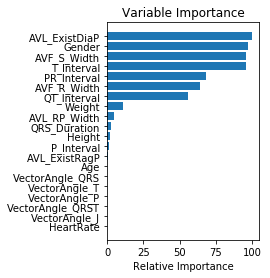

In [149]:
dt = BaggingClassifier(DecisionTreeClassifier(max_depth = 3, random_state=1)).fit(X_train_scaled, y_train)

print("Bagging")
print_model_scores(dt)

dt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, random_state=1)).fit(X_train_scaled, y_train)

print("Boosting")
print_model_scores(dt)
var_imp_plot(dt)

Grid Search on RandomForest to find best estimator

In [150]:
param_grid = {"n_estimators": [50, 200, 500, 700,1000]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid,
                           cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)

Best parameters: {'n_estimators': 500}
Best cross-validation score: 0.61
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


Building model using random forest

training score : 1.0000 
testing score : 0.7279 
Testing report :
             precision    recall  f1-score   support

          1       0.70      0.97      0.81        74
          2       0.75      0.46      0.57        13
          3       0.80      1.00      0.89         4
          4       1.00      0.75      0.86         4
          5       0.00      0.00      0.00         4
          6       1.00      0.25      0.40         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.67      0.80         3
         10       0.77      0.67      0.71        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.67      0.73      0.67       136

Confusion matrix: 
[[72  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 6  6  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  

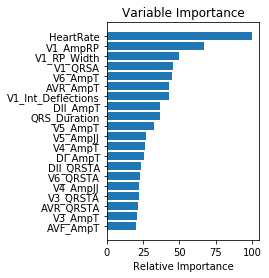

In [76]:
rf_clf = RandomForestClassifier(random_state=1,
                                n_estimators = 1000).fit(X_train_scaled, y_train)

print_model_scores(rf_clf)

var_imp_plot(rf_clf)

Using Grid Search or CV for Gradientboosting to find best estimator

In [78]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
             'max_depth':[3, 5, 9]}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)



Best parameters: {'learning_rate': 0.01, 'max_depth': 3}
Best cross-validation score: 0.72
Best estimator:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)
Best parameters: {'learning_rate': 0.01, 'max_depth': 3}
Best cross-validation score: 0.72
Best estimator:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              

Build model using the best model in GradientBoosting

training score : 0.9525 
testing score : 0.7132 
Testing report :
             precision    recall  f1-score   support

          1       0.71      0.95      0.81        74
          2       0.75      0.46      0.57        13
          3       1.00      1.00      1.00         4
          4       0.67      0.50      0.57         4
          5       0.50      0.50      0.50         4
          6       1.00      0.50      0.67         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.67      0.80         3
         10       0.70      0.47      0.56        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.68      0.71      0.67       136

Confusion matrix: 
[[70  1  0  0  1  0  0  0  0  1  0  0  1]
 [ 5  6  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  

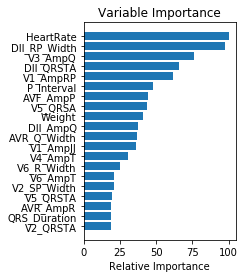

In [80]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.01,max_depth = 3,random_state = 1).fit(X_train_scaled, y_train)

print_model_scores(gb_clf)

var_imp_plot(gb_clf)

Bagging and boosting XGBoost

training score : 0.9272 
testing score : 0.7132 
Testing report :
             precision    recall  f1-score   support

          1       0.69      0.97      0.81        74
          2       0.86      0.46      0.60        13
          3       0.75      0.75      0.75         4
          4       1.00      0.25      0.40         4
          5       0.00      0.00      0.00         4
          6       0.86      0.75      0.80         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.67      0.80         3
         10       0.70      0.47      0.56        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.66      0.71      0.66       136

Confusion matrix: 
[[72  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 5  6  0  0  0  1  0  0  0  1  0  0  0]
 [ 1  0  3  0  0  0  0  0  0  0  

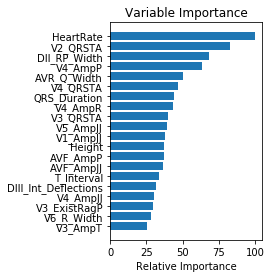

In [81]:
gb_clf = BaggingClassifier(GradientBoostingClassifier(learning_rate = 0.01,
                                                      max_depth =3 ,random_state = 1)).fit(X_train_scaled, y_train)

print_model_scores(gb_clf)

gb_clf = AdaBoostClassifier(GradientBoostingClassifier(learning_rate = 0.01,
                                                       max_depth = 3,random_state = 1)).fit(X_train_scaled, y_train)

print_model_scores(gb_clf)
var_imp_plot(gb_clf)

In [87]:
knn_clf = KNeighborsClassifier()

param_grid = {'n_neighbors':[1, 2, 4, 5, 10]}

grid_search = GridSearchCV(knn_clf , param_grid, cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                               scoring = 'f1_micro',return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)
print("CV results: ", end="")
print(grid_search.cv_results_)

Best parameters: {'n_neighbors': 5}
Best cross-validation score: 0.60
Best estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
CV results: {'mean_fit_time': array([0.0021821 , 0.00198207, 0.00198226, 0.00198293, 0.0019835 ]), 'std_fit_time': array([2.42576234e-04, 2.93012457e-06, 1.71528871e-06, 1.19685177e-06,
       1.16800773e-07]), 'mean_score_time': array([0.00883536, 0.00814357, 0.00814352, 0.00813475, 0.00824299]), 'std_score_time': array([0.00118674, 0.0002362 , 0.00023645, 0.00050619, 0.00039034]), 'param_n_neighbors': masked_array(data=[1, 2, 4, 5, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1}, {'n_neighbors': 2}, {'n_neighbors': 4}, {'n_neighbors': 5}, {'n_neighbors': 10}], 'split0_test_score': array([0.60294118, 0.58823529, 0.60294118, 0.60294118, 0.55882353]),

Build model using the best model in KNN

In [88]:
knn_clf = KNeighborsClassifier(n_neighbors = 5).fit(X_train_scaled, y_train)

print_model_scores(model=knn_clf)

training score : 0.6582 
testing score : 0.5588 
Testing report :
             precision    recall  f1-score   support

          1       0.57      0.95      0.71        74
          2       0.00      0.00      0.00        13
          3       1.00      0.75      0.86         4
          4       1.00      0.25      0.40         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         3
         10       1.00      0.13      0.24        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.48      0.56      0.45       136

Confusion matrix: 
[[70  2  0  0  0  2  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  1  0  0  0  0  

In [89]:
knn_clf = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5)).fit(X_train_scaled, y_train)

print_model_scores(model=knn_clf)

training score : 0.6677 
testing score : 0.5809 
Testing report :
             precision    recall  f1-score   support

          1       0.57      0.96      0.72        74
          2       0.00      0.00      0.00        13
          3       1.00      0.75      0.86         4
          4       1.00      0.25      0.40         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.33      0.50         3
         10       1.00      0.20      0.33        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.50      0.58      0.47       136

Confusion matrix: 
[[71  1  0  0  0  2  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  3  0  0  0  0  0  0  0  

As we can see most of the models here are overfitting the training data. This is also a multiclass classification problem so we have taken AUC as the measure to select few best models. We can reduce a little complexity on those data to give a goodfit instead of the overfit which we have now. The best models considering AUC as the scoring criteria are as follows:  
1) SVC with linear and rbf kernels (AUC ~69 and 69)   
2) GradientBoosting without Bagging and Boosting (AUC ~ 67 )    
3) Decision tree with Bagging (AUC ~ 66)    

In [96]:
pca = decomposition.PCA(n_components=150)
X_pca = pca.fit_transform(X)

X_pca_inv = pca.inverse_transform(X_pca)

print("Variance lost is: ",end="")
print(np.mean(np.sum(np.square(X_pca_inv - X), axis=1))*100, end="")
print("%")

print("Sum of explained variance is: ", end="")
print(np.sum(pca.explained_variance_ratio_)*100,end="")
print("%")

Variance lost is: 92.20877151655958%
Sum of explained variance is: 99.99791220204094%


Splitting the train and test set after pca for model building

In [97]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1, stratify = y)

Grid Seeach on SVC linear kernel to find best parameters

In [98]:
param_grid = {'C': [0.1, 1, 10, 100, 200, 500]}

grid_search = GridSearchCV(SVC(kernel = 'linear', random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_pca, y_train)

print_grid_search(grid_search)

Best parameters: {'C': 0.1}
Best cross-validation score: 0.65
Best estimator:
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)


Building SVC using best parameters

In [99]:
svc = SVC(C=0.1, kernel='linear', random_state=1).fit(X_train_pca, y_train)

print_model_scores(model = svc, X_test_scaled=X_test_pca, X_train_scaled = X_train_pca)

training score : 1.0000 
testing score : 0.6544 
Testing report :
             precision    recall  f1-score   support

          1       0.71      0.88      0.79        74
          2       0.43      0.23      0.30        13
          3       1.00      1.00      1.00         4
          4       0.43      0.75      0.55         4
          5       0.00      0.00      0.00         4
          6       0.57      0.50      0.53         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      1.00      1.00         3
         10       0.67      0.40      0.50        15
         14       0.00      0.00      0.00         1
         15       1.00      1.00      1.00         1
         16       0.00      0.00      0.00         7

avg / total       0.61      0.65      0.62       136

Confusion matrix: 
[[65  2  0  2  0  1  0  0  0  1  0  0  3]
 [ 6  3  0  0  0  1  0  0  0  1  0  0  2]
 [ 0  0  4  0  0  0  0  0  0  0  

Grid search on SVC with rbf kernel to find best parameters

In [100]:
param_grid = {'C': [1, 10, 100, 200, 400, 500],
              'gamma': [0.0001, 0.005, 0.001, 0.01]}

grid_search = GridSearchCV(SVC(kernel = 'rbf', random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_pca, y_train)

print_grid_search(grid_search)

Best parameters: {'C': 10, 'gamma': 0.0001}
Best cross-validation score: 0.54
Best estimator:
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)


Building SVC using best parameters

In [101]:
svc = SVC(C=10, gamma=0.0001, kernel='rbf', random_state=1).fit(X_train_pca, y_train)

print_model_scores(model = svc, X_test_scaled=X_test_pca, X_train_scaled=X_train_pca)

training score : 1.0000 
testing score : 0.5515 
Testing report :
             precision    recall  f1-score   support

          1       0.55      1.00      0.71        74
          2       0.00      0.00      0.00        13
          3       0.00      0.00      0.00         4
          4       0.00      0.00      0.00         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         3
         10       1.00      0.07      0.12        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.41      0.55      0.40       136

Confusion matrix: 
[[74  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  

Grid Search on Decision Tree to find best parameters

In [102]:
param_grid = {'max_depth': np.arange(3, 10)}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_pca, y_train)

print_grid_search(grid_search)

Best parameters: {'max_depth': 4}
Best cross-validation score: 0.59
Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


Training Decision tree using the best parameters

In [103]:
dt = DecisionTreeClassifier(max_depth = 4, random_state=1).fit(X_train_pca, y_train)

print_model_scores(model = dt, X_test_scaled=X_test_pca, X_train_scaled = X_train_pca)

training score : 0.7310 
testing score : 0.5147 
Testing report :
             precision    recall  f1-score   support

          1       0.59      0.85      0.70        74
          2       0.36      0.31      0.33        13
          3       0.00      0.00      0.00         4
          4       0.00      0.00      0.00         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       1.00      0.33      0.50         3
         10       0.22      0.13      0.17        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.40      0.51      0.44       136

Confusion matrix: 
[[63  3  3  1  0  0  0  0  0  4  0  0  0]
 [ 7  4  0  1  0  0  0  0  0  1  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  

Training Decision Tree using PCA

In [104]:
dt = BaggingClassifier(DecisionTreeClassifier(max_depth = 4, random_state=1)).fit(X_train_pca, y_train)

print_model_scores(model = dt, X_test_scaled=X_test_pca, X_train_scaled = X_train_pca)

training score : 0.7405 
testing score : 0.5368 
Testing report :
             precision    recall  f1-score   support

          1       0.57      0.91      0.70        74
          2       0.38      0.23      0.29        13
          3       1.00      0.25      0.40         4
          4       0.00      0.00      0.00         4
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         3
         10       0.22      0.13      0.17        15
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.40      0.54      0.44       136

Confusion matrix: 
[[67  3  0  1  0  0  0  0  0  3  0  0  0]
 [10  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  1  0  0  0  0  0  0  0  

Grid Search on GradientBoost to Find Best Parameters

In [105]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
             'max_depth':[3, 5, 9]}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_pca, y_train)

print_grid_search(grid_search)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best cross-validation score: 0.59
Best estimator:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)


Training Gradient Boosting using AdaBoost

In [ ]:
gb_clf = AdaBoostClassifier(GradientBoostingClassifier(learning_rate = 0.1,max_depth = 5,random_state = 1)).fit(X_train_pca, y_train)

print_model_scores(model = dt, X_test_scaled = X_test_pca, X_train_scaled = X_train_pca)

Summary   
Heart rate undoubtedly won in all the models being the most important variable   
Few other important variables are related to the R' wave, amplitudes in few channels (DII, V6) seeming the most important, age,  weight and QRSA ratio. 
In modeling, AUC was used to determine the model efficiency because there is a class imbalance issue here and accuracy would not  be a good measure to calculate.  
As we can see after pca any model did not perform better than before even though the variance was being captured. 
Dimensionality reduction did not help 
Support Vector Classifier with a linear kernel (C =1) or RBF kernel work well with AUC 71% but, bagging or boosting did not help there. 
Bagging and Boosting did not help 
Decision tree worked well but bagging boosted it's performace with AUC 71%  
Bagging and Boosting helped  
Random Forests did just fine with AUC 68%  
Gradient boosting worked well with bagging and boosting giving AUC approximately 70%  
Bagging and Boosting helped  
All the other models did not work well  

Finally, bagging and boosting may not work always, dimensionality reduction may not help always
We decide to go with the Decision tree model using bagging or SVC classifier using a linear kernel if we had to drill down.